# **Machine Learning: Group Assignment**

*Author: Emre Guler (Snr. 2120268)*

## **Data Description**

**UserID**: a unique ID for each user. Some IDs only occur in the training dataset, some occur only in the test dataset, and most appear in both datasets. For the IDs that that appear in both datasets, the entries in the test dataset all come after (in TimeUtc) the entries in the training dataset.

**QuestionTiming**: binary variable indicating if the question was prompted by the system or the user initiated the question-answering.

**TimeUtc**: time of the response

**CurrentGameMode**: the current mode the user selected to play

**CurrentTask**: the current task/goal in the game the user was working to complete

**CurrentSessionLength**: the amount of time the user has been logged into the game during this session

**LastTaskCompleted**: the previous task/goal in the game that the user completed

**LevelProgressionAmount**: how far (measured as a proportion) the user has progressed to the next level

**QuestionType**: what aspect of mental health is being asked about. In the training and test datasets, these are all questions about "Wellbeing". The supplemental dataset contains answers to other question types from the same set of users.

**ResponseValue**: the score the user gave to the current question. This column is missing in the test dataset.

*Notes*:
- The evaluation metric for this task is Mean Absolute Error.
- Use part of the provided training data as a validation set.
- Start with simple models and simple features, improve from there.
- You are allowed to use the supplemental materials as part of your model, or ignore them.
- The data has more than one observation per person (over time), consider using that information. 

## **Competition Details**

**Codalab submission**
You will need to submit your prediction file to the competition server. The competition is hosted on Codalab at the following URL: https://codalab.lisn.upsaclay.fr/competitions/19116?secret_key=9e2695a9-5327-459d-99a1-9b765cd6750bLinks to an external site.

Each group will need to register one codalab account (using a tiburguniversity.edu email), and that account will be responsible for submitting your predictions. 

You can upload your predictions in the Participate link. The results from all the participating teams will be displayed in the Results tab.

Over the course of the competition each group can make 6 total submissions. The best score on the competition server for each group will be used to calculate the bonus points awarded as part of the assignment.

Note that if you submission fails for some reason such as incorrect format, this is still counted as one of the allowed submissions.

**Submission Details**
Your submission must be a single .zip file that, when unzipped, creates a single file named predicted.csv. No other folders or files should be created when unzipping your submission (Make sure there are not additional subdirectories in the zip file).

predicted.csv should contain one row for each row in test_data.csv. It should contain only one column of values without row names or column names. The exact format of a well-formed predicted.csv file is created by the baseline example notebook. Any deviation from this structure might produce an error when evaluating your submission to the competition server (and count against one of your submissions).

After a submission is uploaded, the status will be listed as 'Submitted'. In some cases, it can take 20+ minutes for the server to process a submission where a score is calculated and the status is 'Finished', please be patient. After the status is Finished, you can submit the result to the leaderboard if you would like. You can already view the performance of the baseline solution on the leaderboard (submitted by the account ahendric.)

**Evaluation metric**
The evaluation metric for this task is Mean Absolute Error. Specifically, given the path to the true values (gold_path) and the path to a submission (pred_path) the following Python code is used for evaluation of the predictions:


## **Code**

### 1. Module Installation

In [1]:
# data manipulation and exploratory data analysis tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# pipeline tools
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_absolute_error

# regression models for prediction
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
# from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

### 2. Data Reading

In [2]:
# reading the data sets
train = pd.read_csv("train_data.csv")
supplement = pd.read_csv("supplimental_data.csv")
challenge = pd.read_csv("test_data.csv")

# setting up useful dictionaries and lists for basic set operations
datasetList = {'training':train, 'supplement':supplement, 'challenge':challenge}
catFeatures = ['UserID', 'QuestionTiming', 'CurrentGameMode', 'CurrentTask','LastTaskCompleted','QuestionType']
nullColumns = ['CurrentGameMode', 'CurrentTask', 'LastTaskCompleted', 'LevelProgressionAmount']

### 3. Data Inspection

- The actual test data (challenge) does not have a ResponseValue column, it has to be predicted and uploaded to Codalab.
- Dataset Lengths: supplement > training > challenge.

In [3]:
# dataset dimensions
for eachSet in datasetList:
    print(f"{eachSet} data dimensions:\n{datasetList[eachSet].shape}\n")    

training data dimensions:
(134420, 10)

supplement data dimensions:
(294726, 10)

challenge data dimensions:
(60832, 9)



Pandas is able to identify the numeric features, but the categorical features needs to be converted.

In [4]:
# variable information for each dataset
for eachSet in datasetList:
    print(f"{eachSet} data dimensions:\n{datasetList[eachSet].info()}\n")    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134420 entries, 0 to 134419
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   UserID                  134420 non-null  object 
 1   QuestionTiming          134420 non-null  object 
 2   TimeUtc                 134420 non-null  object 
 3   CurrentGameMode         117407 non-null  object 
 4   CurrentTask             117407 non-null  object 
 5   CurrentSessionLength    134420 non-null  int64  
 6   LastTaskCompleted       71815 non-null   object 
 7   LevelProgressionAmount  117402 non-null  float64
 8   QuestionType            134420 non-null  object 
 9   ResponseValue           134420 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 10.3+ MB
training data dimensions:
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294726 entries, 0 to 294725
Data columns (total 10 columns):
 #   Column                  Non-Nu

- Training data has highest number of null values.
- Challenge data has null values in the same columns as the training data, but less.
- Supplement data only has null values in the LastTaskCompleted column but the null ratio is too high.

In [104]:
# dataset null counts
for eachSet in datasetList:
    print(f"{eachSet} null count percentage:\n{round(datasetList[eachSet].isna().sum() / datasetList[eachSet].shape[0], 2)}\n")    

training null count percentage:
UserID                    0.00
QuestionTiming            0.00
TimeUtc                   0.00
CurrentGameMode           0.13
CurrentTask               0.13
CurrentSessionLength      0.00
LastTaskCompleted         0.47
LevelProgressionAmount    0.13
QuestionType              0.00
ResponseValue             0.00
dtype: float64

supplement null count percentage:
UserID                    0.00
QuestionTiming            0.00
TimeUtc                   0.00
CurrentGameMode           0.00
CurrentTask               0.00
CurrentSessionLength      0.00
LastTaskCompleted         0.43
LevelProgressionAmount    0.00
QuestionType              0.00
ResponseValue             0.00
dtype: float64

challenge null count percentage:
UserID                    0.00
QuestionTiming            0.00
TimeUtc                   0.00
CurrentGameMode           0.17
CurrentTask               0.17
CurrentSessionLength      0.00
LastTaskCompleted         0.60
LevelProgressionAmount    0.17
Q

In [259]:
def nullInfo(df: pd.DataFrame):
    print(df.isna().sum())

In [6]:
# inspect the training data heading
train.head()

,UserID,QuestionTiming,TimeUtc,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue
0,p1,User Initiated,2022-08-18 22:55:27,NaN,NaN,2,NaN,NaN,Wellbeing,509.0
1,p1,System Initiated,2022-08-18 23:38:31,NaN,NaN,0,NaN,NaN,Wellbeing,653.0
2,p1,User Initiated,2022-08-18 23:39:24,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705.0
3,p1,System Initiated,2022-08-18 23:45:01,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817.0
4,p1,System Initiated,2022-08-18 23:51:22,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810.0


The feature depth of UserID, CurrentTask and LastTaskCompleted is too large.

In [7]:
# occurrence count of categorical features
for nextColumn in list(train[catFeatures].columns):
    print(f"{train[nextColumn].value_counts(dropna=False)}\n")

UserID
p2852    453
p8336    300
p8525    261
p2956    251
p3707    245
        ... 
p178       1
p1743      1
p1722      1
p4121      1
p3650      1
Name: count, Length: 8169, dtype: int64

QuestionTiming
System Initiated    115429
User Initiated       18991
Name: count, dtype: int64

CurrentGameMode
Career       110722
NaN           17013
Special        4404
FreePlay       2265
Challenge        16
Name: count, dtype: int64

CurrentTask
RECREATIONGROUND_PLAYGROUND        18038
NaN                                17013
RESIDENTIALSMALL_BACKYARD          13840
SUBURBIA_DETACHEDHOUSE             10635
RECREATIONGROUND_SKATEPARK          8543
RESIDENTIALSMALL_BUNGALOW           8443
FIRESTATION_FIRESTATION             6966
NATIONALPARK_TREEHOUSE              4730
NATIONALPARK_STORYBOOKHOUSE         4560
NATIONALPARK_SHOEHOUSE              3726
HOME_VAN                            3358
SUBWAY_SUBWAYPLATFORM               2649
FAIRGROUND_MERRYGOROUND             2588
COUNTRYSIDE_TEMPLE       

### 4. Data Exploration
- This section includes analysis of various feature correlations, distributions and pattern recognition attempts.
- **Important: None of the code in this part should change/manipulate dataset variables.**

#### **Null Feature Frequencies**
After the group of null-less instances, the next largest instance group have only 1 null value, but there is still a considerable amount of instances with 4 null values.

In [11]:
train.isnull().sum(axis=1).value_counts(dropna=False)

0    71813
1    45589
4    17011
2        5
3        2
Name: count, dtype: int64

#### **Session Length of Complete Nulls**
Below code highlights that a large proportion of instances **with all 4 null values** have between 0-2 minutes of gameplay.

In [190]:
train[train.isnull().sum(axis=1) == 4].CurrentSessionLength.value_counts(dropna=False)[:20]

CurrentSessionLength
0     14281
1      1358
2       578
3       240
4       118
5        77
6        52
7        45
8        41
9        22
11       18
10       13
12       12
13       10
15        9
23        8
16        8
19        7
22        6
14        6
Name: count, dtype: int64

#### **Category Distribution of 1-Null Rows**

All of the 1-null rows have one thing in common: They all have 'LastTaskCompleted' as the null column.

In [13]:
train[train.isnull().sum(axis=1) == 1].isnull().sum(axis=0)

UserID                        0
QuestionTiming                0
TimeStamp                     0
CurrentGameMode               0
CurrentTask                   0
CurrentSessionLength          0
LastTaskCompleted         45589
LevelProgressionAmount        0
QuestionType                  0
ResponseValue                 0
dtype: int64

In [14]:
train[train.isnull().sum(axis=1) == 1].CurrentSessionLength.value_counts()[:50]

CurrentSessionLength
9     1871
8     1797
10    1718
7     1683
6     1433
16    1247
17    1119
15    1112
18    1008
14     923
11     889
24     873
19     848
25     847
20     790
23     775
22     764
26     762
13     724
21     711
27     675
12     667
28     656
30     654
32     653
31     640
33     629
29     621
36     597
35     550
37     530
34     528
38     527
39     519
41     502
40     500
43     439
42     434
45     404
44     397
0      392
5      383
47     372
46     371
3      307
2      305
1      289
48     288
50     286
49     278
Name: count, dtype: int64

#### **Session Length Outliers**

Sessions that are longer than 1 day: 9
Sessions that are between 24 and 12 hours: 646
Sessions that are between 12 and 6 hours: 3619
Sessions that are less than 6 hours: 130110


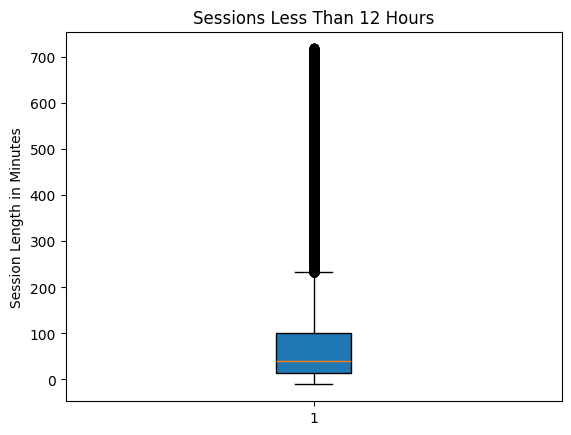

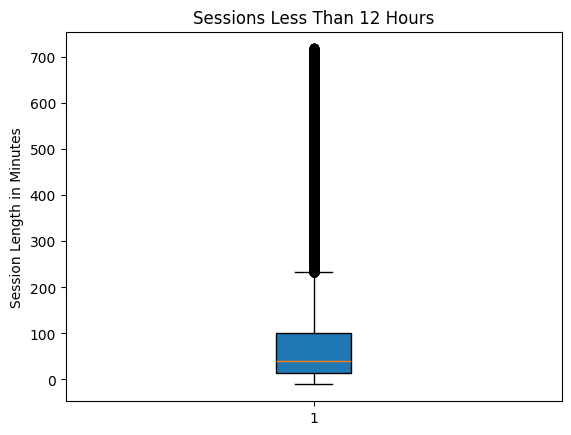

In [83]:
print(f"Sessions that are longer than 1 day: {train.CurrentSessionLength[train.CurrentSessionLength > 60*24].shape[0]}")
print(f"Sessions that are between 24 and 12 hours: {train.CurrentSessionLength[(train.CurrentSessionLength > 60*12) & (train.CurrentSessionLength < 60*24)].shape[0]}")
print(f"Sessions that are between 12 and 6 hours: {train.CurrentSessionLength[(train.CurrentSessionLength > 60*6) & (train.CurrentSessionLength < 60*12)].shape[0]}")
print(f"Sessions that are less than 6 hours: {train.CurrentSessionLength[train.CurrentSessionLength < 60*6].shape[0]}")

plt.figure(), plt.boxplot(train.CurrentSessionLength[train.CurrentSessionLength < 60*12], vert=True, patch_artist=True)
plt.title("Sessions Less Than 12 Hours")
plt.ylabel('Session Length in Minutes')
plt.show()

plt.figure(), plt.boxplot(train.CurrentSessionLength[train.CurrentSessionLength < 60*12], vert=True, patch_artist=True)
plt.title("Sessions Less Than 12 Hours")
plt.ylabel('Session Length in Minutes')
plt.show()

#### **0-2 Minute Sessions: Categorical Frequency Tables & LevelProgression Histogram**

CurrentGameMode
NaN          16218
Career         971
Special         52
FreePlay        14
Challenge        1
Name: count, dtype: int64

CurrentTask
NaN                                16218
HOME_VAN                             232
RECREATIONGROUND_PLAYGROUND          182
RESIDENTIALSMALL_BACKYARD            116
RESIDENTIALSMALL_BUNGALOW            106
SUBURBIA_DETACHEDHOUSE                89
RECREATIONGROUND_SKATEPARK            58
HOME_DIRTBIKE                         28
NATIONALPARK_SHOEHOUSE                25
NATIONALPARK_STORYBOOKHOUSE           24
MARS_MARSROVER                        24
FIRESTATION_FIRESTATION               21
HOME_GOLFCART                         20
RECREATIONGROUND_FOUNTAIN             11
RECREATIONGROUND_MINIGOLF             11
SUBURBIA_VINTAGECAR                    9
SUBWAY_SUBWAYWASHROOM                  9
NATIONALPARK_TREEHOUSE                 8
SUBWAY_SUBWAYPLATFORM                  6
HOME_DRILL                             6
FAIRGROUND_HELTERSKELTER      

(<Axes: title={'center': 'LevelProgressionAmount: SessionLength <= 2'}>,
 Text(0.5, 1.0, 'LevelProgressionAmount: SessionLength <= 2'))

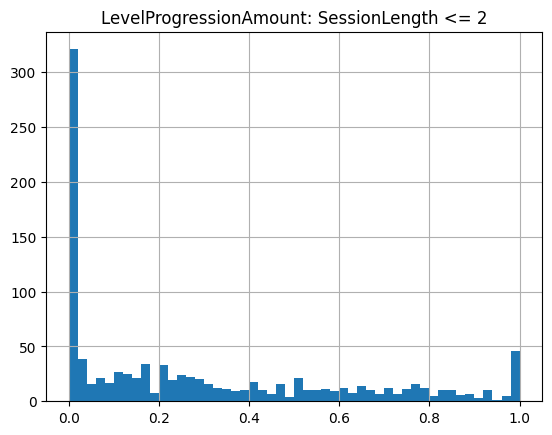

In [16]:
sessionLimit = 2
print(f"{train[train.CurrentSessionLength <= sessionLimit].CurrentGameMode.value_counts(dropna=False)}\n")
print(f"{train[train.CurrentSessionLength <= sessionLimit].CurrentTask.value_counts(dropna=False)}\n")
print(f"{train[train.CurrentSessionLength <= sessionLimit].LastTaskCompleted.value_counts(dropna=False)}\n")

train[train.CurrentSessionLength <= sessionLimit].LevelProgressionAmount.hist(bins=50), plt.title(f'LevelProgressionAmount: SessionLength <= {sessionLimit}')

#### **0-2 Minute Sessions: ResponseValue Distribution/Mean**

0 minute session length, mean responseValue: 680.9598664486236
1 minute session length, mean responseValue: 663.7616173808087
2 minute session length, mean responseValue: 667.9349240780911


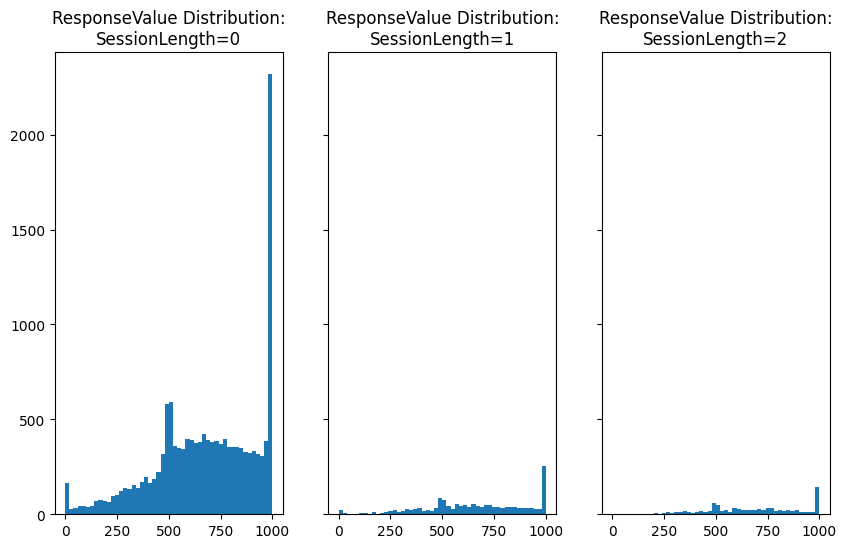

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True)

for i in range(0,3):
    axes[i].hist(train[train.CurrentSessionLength == i].ResponseValue, bins=50), axes[i].set_title(f"ResponseValue Distribution:\nSessionLength={i}")
    print(f"{i} minute session length, mean responseValue: {train[train.CurrentSessionLength == i].ResponseValue.mean()}")

#### **ResponseValue Range For Each QuestionType**

Below code demonstrates that all of the question type's max response value is upper-floored by 1000:

In [18]:
print(f"{train.QuestionType.unique()[0]} Max ResponseValue: {train.ResponseValue.max()}")

for eachQuestion in supplement.QuestionType.unique():
    print(f"{eachQuestion} Max ResponseValue: {supplement[supplement.QuestionType == eachQuestion].ResponseValue.max()}")

Wellbeing Max ResponseValue: 1000.0
Focus Max ResponseValue: 1000.0
Enjoyment Max ResponseValue: 1000.0
Immersion Max ResponseValue: 1000.0
Autonomy Max ResponseValue: 1000.0
Competence Max ResponseValue: 1000.0


The ResponseValue distributions of all the question types have very high count of 1000 points:

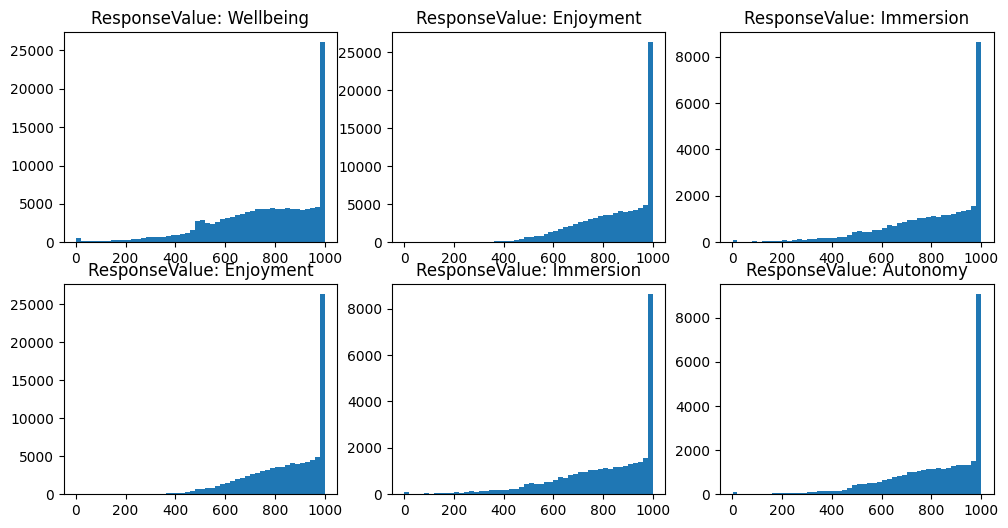

In [19]:
questionTypes = supplement.QuestionType.unique()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))

for i in range(0,2):
    for j in range(0,3):
        if i == 0 and j == 0:
            axes[i,j].hist(train.ResponseValue, bins=50), axes[0,0].set_title(f"ResponseValue: {train.QuestionType.unique()[0]}")
        else:
            axes[i,j].hist(supplement[supplement.QuestionType == questionTypes[i+j]].ResponseValue, bins=50), axes[i,j].set_title(f"ResponseValue: {questionTypes[i+j]}")

plt.show()

#### **Mean ResponseValue of Each Current Task**

In [20]:
train.groupby('CurrentTask', observed=True).describe().ResponseValue.sort_values('count', ascending=False)

,count,mean,min,25%,50%,75%,max,std
CurrentTask,,,,,,,,
RECREATIONGROUND_PLAYGROUND,18038.0,764.531655,1.0,639.00,795.0,942.00,1000.0,204.636696
RESIDENTIALSMALL_BACKYARD,13840.0,765.158454,1.0,639.00,792.0,945.00,1000.0,201.563677
SUBURBIA_DETACHEDHOUSE,10635.0,766.134086,1.0,642.00,802.0,945.00,1000.0,208.033902
RECREATIONGROUND_SKATEPARK,8543.0,773.367435,1.0,649.00,811.0,953.50,1000.0,207.838173
RESIDENTIALSMALL_BUNGALOW,8443.0,764.333886,1.0,639.50,793.0,945.00,1000.0,204.803790
FIRESTATION_FIRESTATION,6966.0,777.602067,1.0,653.00,814.0,953.00,1000.0,200.029930
NATIONALPARK_TREEHOUSE,4730.0,776.829810,1.0,645.25,814.0,960.00,1000.0,206.038010
NATIONALPARK_STORYBOOKHOUSE,4560.0,775.654167,1.0,658.00,810.0,956.00,1000.0,205.717389
NATIONALPARK_SHOEHOUSE,3726.0,771.813741,1.0,651.00,799.5,948.75,1000.0,201.797298


#### **UserID Frequency Histogram**

(<Axes: title={'center': 'test'}, xlabel='te'>,
 Text(0.5, 1.0, 'test'),
 Text(0.5, 0, 'te'))

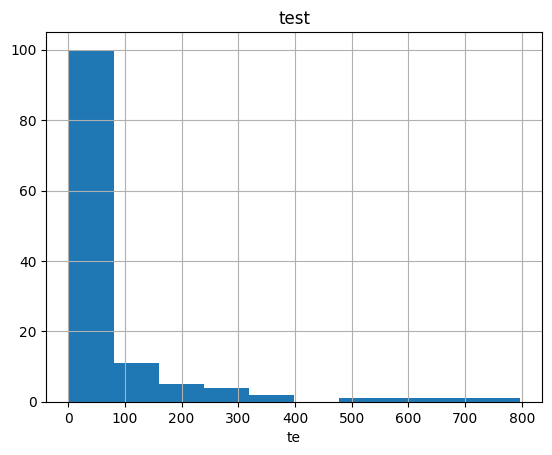

In [21]:
train.UserID.value_counts().value_counts().hist(), plt.title('test'), plt.xlabel('te')

#### **Difference Between User or System Initiation**

In [22]:
train.groupby('QuestionTiming', observed=True).describe().ResponseValue
# train.groupby('CurrentTask', observed=True).describe().ResponseValue.sort_values('count', ascending=False)

# train[train.QuestionTiming == 'User Initiated'].ResponseValue.hist(bins=50)
# train[train.QuestionTiming == 'System Initiated'].ResponseValue.hist(bins=50)

,count,mean,min,25%,50%,75%,max,std
QuestionTiming,,,,,,,,
System Initiated,115429.0,761.218255,1.0,629.0,795.0,948.0,1000.0,211.412202
User Initiated,18991.0,745.897952,1.0,606.0,782.0,938.0,1000.0,220.732932


#### **Overlaps of UserIDs Between Datasets**

<img src="userID_overlap.png" width="629" height="426">

In [356]:
userListTrain = set(train.UserID.unique())
userListSupplement = set(supplement.UserID.unique())
userListChallenge = set(challenge.UserID.unique())

print(f"train: {len(userListTrain)}")
print(f"train - supplement - test: {len(userListTrain.difference(userListSupplement, userListChallenge))}")
print(f"train & supplement & test: {len(userListTrain.intersection(userListSupplement, userListChallenge))}")
print(f"train & supplement: {len(userListTrain.intersection(userListSupplement))}")
print(f"train & test: {len(userListTrain.intersection(userListChallenge))}\n")

print(f"supplement: {len(userListSupplement)}")
print(f"supplement - train - test: {len(userListSupplement.difference(userListTrain, userListChallenge))}")
print(f"supplement & train & test: {len(userListSupplement.intersection(userListTrain, userListChallenge))}")
print(f"supplement & train: {len(userListSupplement.intersection(userListTrain))}")
print(f"supplement & test: {len(userListSupplement.intersection(userListChallenge))}\n")

print(f"test: {len(userListChallenge)}")
print(f"test - train - supplement: {userListChallenge.difference(userListTrain, userListSupplement)}")
print(f"test & train & supplement: {len(userListChallenge.intersection(userListTrain, userListSupplement))}")
print(f"test & train: {len(userListChallenge.intersection(userListTrain))}")
print(f"test & supplement: {len(userListChallenge.intersection(userListSupplement))}\n")

train: 8169
train - supplement - test: 2965
train & supplement & test: 5204
train & supplement: 5204
train & test: 5204

supplement: 5204
supplement - train - test: 0
supplement & train & test: 5204
supplement & train: 5204
supplement & test: 5204

test: 6451
test - train - supplement: {'p2100', 'p5458', 'p9976', 'p9540', 'p10853', 'p1447', 'p3827', 'p1611', 'p7168', 'p761', 'p10798', 'p933', 'p6368', 'p9507', 'p7022', 'p1756', 'p7541', 'p4986', 'p8693', 'p8773', 'p10000', 'p7276', 'p9428', 'p3253', 'p9649', 'p7702', 'p6274', 'p8843', 'p3916', 'p263', 'p7784', 'p5065', 'p9532', 'p2841', 'p6623', 'p11142', 'p5446', 'p42', 'p946', 'p10941', 'p2475', 'p7765', 'p1912', 'p5731', 'p7477', 'p2467', 'p10068', 'p10965', 'p5586', 'p6389', 'p11306', 'p4022', 'p505', 'p6040', 'p11199', 'p1975', 'p9598', 'p9038', 'p7076', 'p1672', 'p6536', 'p3654', 'p9217', 'p3676', 'p7550', 'p345', 'p10010', 'p9520', 'p8873', 'p9026', 'p10800', 'p6701', 'p9671', 'p1317', 'p4478', 'p9489', 'p6090', 'p7849', 'p8849'

#### **Correlation Between Wellbeing and Other ResponseValues (via overlapping users)**

In [68]:
# supplement[supplement.UserID.isin(train.UserID.unique())].groupby('UserID', observed=True).describe()

# Concatenate the dataframes
combined = pd.concat([train, supplement])

# Identify users who have scores for all question types
required_question_types = combined['QuestionType'].unique()
user_question_counts = combined.groupby('UserID')['QuestionType'].nunique()
valid_users = user_question_counts[user_question_counts == len(required_question_types)].index

# Filter the combined DataFrame to include only these users
filtered_combined = combined[combined['UserID'].isin(valid_users)]

# Group by UserID and QuestionType, then calculate the mean Score
grouped = filtered_combined.groupby(['UserID', 'QuestionType'])['ResponseValue'].mean().reset_index()

# Extract means for each QuestionType into separate arrays
mean_scores = {qtype: grouped[grouped['QuestionType'] == qtype]['ResponseValue'].values for qtype in required_question_types}

# Calculate the correlation matrix of all question types
print(f"Based on the users that hava a complete set of questionType scores:")
pd.DataFrame(mean_scores).corr()

Based on the users that hava a complete set of questionType scores:


,Wellbeing,Focus,Enjoyment,Immersion,Autonomy,Competence
Wellbeing,1.000000,0.607683,0.725251,0.645395,0.665361,0.633426
Focus,0.607683,1.000000,0.710066,0.835201,0.662060,0.594390
Enjoyment,0.725251,0.710066,1.000000,0.740168,0.803646,0.756836
Immersion,0.645395,0.835201,0.740168,1.000000,0.725654,0.647912
Autonomy,0.665361,0.662060,0.803646,0.725654,1.000000,0.734898
Competence,0.633426,0.594390,0.756836,0.647912,0.734898,1.000000


#### **Null Entry Clustering**

In [72]:
# training data inspection
print(f"Training set null row counts:\n{train.isnull().sum(axis=0)}\n")
print(f"All null rows: {train[train.isnull().sum(axis=1) > 0].shape[0]}")

print(f"4-null rows: {train[train.isnull().sum(axis=1) == 4].shape[0]}")

print(f"3-null rows: {train[train.isnull().sum(axis=1) == 3].shape[0]}")
print(f"{train.loc[train.isnull().sum(axis=1) == 3, ['CurrentGameMode', 'CurrentTask', 'LastTaskCompleted', 'LevelProgressionAmount']]}")

print(f"2-null rows: {train[train.isnull().sum(axis=1) == 2].shape[0]}")
print(f"{train.loc[train.isnull().sum(axis=1) == 2, ['CurrentGameMode', 'CurrentTask', 'LastTaskCompleted', 'LevelProgressionAmount']]}")

print(f"1-null rows: {train[train.isnull().sum(axis=1) == 1].shape[0]}")
print(f"1-null CurrentGameMode: {train.loc[(train.isnull().sum(axis=1) == 1) & (train.CurrentGameMode.isnull())].shape[0]}")
print(f"1-null CurrentTask: {train.loc[(train.isnull().sum(axis=1) == 1) & (train.CurrentTask.isnull())].shape[0]}")
print(f"1-null LevelProgressionAmount: {train.loc[(train.isnull().sum(axis=1) == 1) & (train.LevelProgressionAmount.isnull())].shape[0]}")
print(f"1-null LastTaskCompleted: {train.loc[(train.isnull().sum(axis=1) == 1) & (train.LastTaskCompleted.isnull())].shape[0]}\n")
# print(f"{train.loc[(train.isnull().sum(axis=1) == 1) & (train.LastTaskCompleted.isnull())].CurrentTask.value_counts(dropna=False)}")

Training set null row counts:
UserID                        0
QuestionTiming                0
TimeUtc                       0
CurrentGameMode           17013
CurrentTask               17013
CurrentSessionLength          0
LastTaskCompleted         62605
LevelProgressionAmount    17018
QuestionType                  0
ResponseValue                 0
dtype: int64

All null rows: 62607
4-null rows: 17011
3-null rows: 2
      CurrentGameMode CurrentTask LastTaskCompleted  LevelProgressionAmount
7493              NaN         NaN        WASH_PWVan                     NaN
85902             NaN         NaN     WASH_Backyard                     NaN
2-null rows: 5
       CurrentGameMode                  CurrentTask LastTaskCompleted  \
10959          Special               MARS_MARSROVER               NaN   
71189         FreePlay  RECREATIONGROUND_PLAYGROUND               NaN   
79036          Special               MARS_MARSROVER               NaN   
84992          Special               MARS_MARS

In [73]:
# Challenge data inspection
print(f"Challenge set null row counts:\n{challenge.isnull().sum(axis=0)}\n")
print(f"All null rows: {challenge[challenge.isnull().sum(axis=1) > 0].shape[0]}")

print(f"4-null rows: {challenge[challenge.isnull().sum(axis=1) == 4].shape[0]}")

print(f"3-null rows: {challenge[challenge.isnull().sum(axis=1) == 3].shape[0]}")
print(f"{challenge.loc[challenge.isnull().sum(axis=1) == 3, ['CurrentGameMode', 'CurrentTask', 'LastTaskCompleted', 'LevelProgressionAmount']]}")

print(f"2-null rows: {challenge[challenge.isnull().sum(axis=1) == 2].shape[0]}")
print(f"{challenge.loc[challenge.isnull().sum(axis=1) == 2, ['CurrentGameMode', 'CurrentTask', 'LastTaskCompleted', 'LevelProgressionAmount']]}")

print(f"1-null rows: {challenge[challenge.isnull().sum(axis=1) == 1].shape[0]}")
print(f"1-null CurrentGameMode: {challenge.loc[(challenge.isnull().sum(axis=1) == 1) & (train.CurrentGameMode.isnull())].shape[0]}")
print(f"1-null CurrentTask: {challenge.loc[(challenge.isnull().sum(axis=1) == 1) & (train.CurrentTask.isnull())].shape[0]}")
print(f"1-null LevelProgressionAmount: {challenge.loc[(challenge.isnull().sum(axis=1) == 1) & (train.LevelProgressionAmount.isnull())].shape[0]}")
print(f"1-null LastTaskCompleted: {challenge.loc[(challenge.isnull().sum(axis=1) == 1) & (train.LastTaskCompleted.isnull())].shape[0]}\n")
# print(f"{train.loc[(train.isnull().sum(axis=1) == 1) & (train.LastTaskCompleted.isnull())].CurrentTask.value_counts(dropna=False)}")

Challenge set null row counts:
UserID                        0
QuestionTiming                0
TimeUtc                       0
CurrentGameMode           10333
CurrentTask               10333
CurrentSessionLength          0
LastTaskCompleted         36801
LevelProgressionAmount    10335
QuestionType                  0
dtype: int64

All null rows: 36805
4-null rows: 10330
3-null rows: 3
      CurrentGameMode CurrentTask   LastTaskCompleted  LevelProgressionAmount
6062              NaN         NaN      WASH_SeaTemple                     NaN
39329             NaN         NaN      WASH_SeaTemple                     NaN
49341             NaN         NaN  WASH_ClimbingFrame                     NaN
2-null rows: 1
     CurrentGameMode             CurrentTask LastTaskCompleted  \
1191         Special  DESERT_STEAMLOCOMOTIVE               NaN   

      LevelProgressionAmount  
1191                     NaN  
1-null rows: 26471
1-null CurrentGameMode: 3113
1-null CurrentTask: 3113
1-null LevelProgr

### 5. Feature Engineering

**Below feature engineering operations are applied to all sets:**
1) Categorical and Time Conversion
2) Datetime extraction from TimeStamp feature
3) QuestionTiming binary conversion
4) SessionLength outlier handling (outlier deletion and log transformation)
5) CurrentTask & LastTaskCompleted Outlier Cleaning
6) Imputation: Filling 4-null rows (NEW_SESSION if sessionLength is low, remove if sessionLength is above a limit)
7) UserID Descriptive Statistics Extraction

**Possible Feature Transformations:**
- Using CatBoost to rank features by importance: https://catboost.ai/en/docs/concepts/python-quickstart#regression
- Dropping ProgressionAmount: Wiktor said it almost has no effect
- CurrentTask and LastTaskCompleted imputation: By using Random Forest Classifiers
- GameMode imputation: By extracting the most popular category per user
- CurrentTask and LastTask text vectorization using BERT or similar pre-trained models
- Discarding entries that belong to sessions with less than 3 entries
- Discarding users that have only one session

#### 5.1. Categorical Conversion

In [16]:
def categoryConversion(df: pd.DataFrame, catFeatures: list):
    # convert the categorical features
    for nextCatFeature in catFeatures:
        if nextCatFeature in df.columns:
            df[nextCatFeature] = pd.Categorical(df[nextCatFeature])
    
    print(f"categoryConversion Success")
    return df

#### 5.2. TimeSeries Conversion

In [17]:
def timeConversion(df: pd.DataFrame):
    # convert timestamp column to datetime
    if 'TimeUtc' in df.columns:
        df.TimeUtc = pd.to_datetime(df.TimeUtc)
        df = df.rename(columns={'TimeUtc': 'TimeStamp'})
    
    print(f"timeConversion Success")
    return df

#### 5.3. Datetime Feature Extraction

In [18]:
def datetimeExtraction(df: pd.DataFrame):

    if 'TimeStamp' in df.columns:
    # extract all the date information onto separate columns
        df['Year'] = df.TimeStamp.dt.year
        df['Month'] = df.TimeStamp.dt.month
        df['Day'] = df.TimeStamp.dt.day
        df['Hour'] = df.TimeStamp.dt.hour
        df['Weekday'] = df.TimeStamp.dt.day_of_week

        # convert 'Weekday' column into weekend binary
        df.rename(columns={'Weekday': 'Weekend'}, inplace=True)
        df.Weekend = df.Weekend > 4.5

        # update the column order
        if 'ResponseValue' in df.columns:
            df = df[['UserID',
                    'QuestionTiming',
                    'TimeStamp',
                    'Year',
                    'Month',
                    'Day',
                    'Hour',
                    'Weekend',
                    'CurrentGameMode',
                    'CurrentTask',
                    'CurrentSessionLength',
                    'LastTaskCompleted',
                    'LevelProgressionAmount',
                    'QuestionType',
                    'ResponseValue']]
        else:
            df = df[['UserID',
                    'QuestionTiming',
                    'TimeStamp',
                    'Year',
                    'Month',
                    'Day',
                    'Hour',
                    'Weekend',
                    'CurrentGameMode',
                    'CurrentTask',
                    'CurrentSessionLength',
                    'LastTaskCompleted',
                    'LevelProgressionAmount',
                    'QuestionType']]
        
        # return the modified dataframe
        print(f"datetimeExtraction Success")
        return df
    else:
        print(f"datetimeExtraction Error: The dataframe does not have the column 'TimeStamp', input dataframe returned.")
        return df

#### 5.4. QuestionTiming Binary Conversion

QuestionTiming column only has two categorical values: 'System Initiated' or 'User Initiated' which can be converted into a single binary information.

In [19]:
def questionTimingConversion(df: pd.DataFrame):
    # convert 'QuestionTiming' column into binary
    if 'QuestionTiming' in df.columns:
        df.rename(columns={'QuestionTiming': 'SystemPrompt'}, inplace=True)
        df.SystemPrompt = df.SystemPrompt == 'System Initiated'
        print(f"questionTimingConversion Success")
        return df
    else:
        print(f"questionTimingConversion Error: The dataframe does not have the column 'QuestionTiming', input dataframe returned.")
        return df

#### 5.5. Outlier Removal

##### SessionLength Outlier Cleaning

- The session histogram for different session intervals are given below.
- The function removes the session that are longer than the given time limit and that have negative value.
- Log transformation is also prepared if necessary.

In [20]:
# only numerical feature without a limit is CurrentSessionLength
for hour in range(0, 48):
    hourlySubset = train[(train.CurrentSessionLength > 60*hour) & (train.CurrentSessionLength < 60*(hour+1))]
    print(f"Sessions between {hour}-{hour+1}: {hourlySubset.shape[0]} with a mean ResponseValue of {hourlySubset.ResponseValue.mean()}")

Sessions between 0-1: 68185 with a mean ResponseValue of 759.5407054337464
Sessions between 1-2: 23858 with a mean ResponseValue of 779.4712465420404
Sessions between 2-3: 11021 with a mean ResponseValue of 783.1619635241811
Sessions between 3-4: 5987 with a mean ResponseValue of 785.2928010689828
Sessions between 4-5: 3439 with a mean ResponseValue of 774.5091596394301
Sessions between 5-6: 2078 with a mean ResponseValue of 776.4071222329163
Sessions between 6-7: 1310 with a mean ResponseValue of 779.6167938931297
Sessions between 7-8: 829 with a mean ResponseValue of 750.8950542822678
Sessions between 8-9: 571 with a mean ResponseValue of 793.8038528896673
Sessions between 9-10: 404 with a mean ResponseValue of 797.8663366336634
Sessions between 10-11: 278 with a mean ResponseValue of 804.068345323741
Sessions between 11-12: 184 with a mean ResponseValue of 819.4130434782609
Sessions between 12-13: 119 with a mean ResponseValue of 805.0
Sessions between 13-14: 82 with a mean Response

In [21]:
def sessionOutlierRemoval(df: pd.DataFrame, hourLimit=12):
    if 'CurrentSessionLength' in df.columns:
        df_new = df[(df.CurrentSessionLength < hourLimit * 60) & (df.CurrentSessionLength > 0)]
        print(f"sessionOutlierRemoval Success: {df.shape[0] - df_new.shape[0]} entries more than {hourLimit} hours of sessionLength removed.")
        return df_new
    else:
        print(f"sessionOutlierRemoval Error: Dataframe does not have the column 'CurrentSessionLength', original input returned.")
        return df

In [22]:
def sessionLogTransform(df: pd.DataFrame):
    if 'CurrentSessionLength' in df.columns:
        df.CurrentSessionLength = np.log(df.CurrentSessionLength + 1)
        print(f"sessionLogTransform Success: SessionLength column has ben successfully log transformed.")
        return df
    else:
        print(f"sessionLogTransform Error: Dataframe does not have the column 'CurrentSessionLength', original input returned.")
        return df

##### CurrentTask Outlier Cleaning

In [23]:
def currentTaskOutlierRemoval(df: pd.DataFrame, pctLimit: float):
    if 'CurrentTask' in df.columns:
        columnPcts = df.CurrentTask.value_counts(dropna=False) / df.CurrentTask.shape[0]
        keptFeatures = columnPcts[columnPcts > pctLimit].index.to_list()
        removedFeatures = columnPcts[columnPcts < pctLimit].index.to_list()
        print(f"currentTaskOutlierRemoval Success: These features have been successfully removed from 'CurrentTask' column: {removedFeatures}")
        df = df[df.CurrentTask.isin(keptFeatures)]
    else:
        print(f"currentTaskOutlierRemoval Error: Dataframe does not have the column 'CurrentTask'.")
    return df

#####  LastTaskCompleted Outlier Cleaning

In [24]:
def lastTaskOutlierRemoval(df: pd.DataFrame, pctLimit: float):
    if 'LastTaskCompleted' in df.columns:
        columnPcts = df.LastTaskCompleted.value_counts(dropna=False) / df.LastTaskCompleted.shape[0]
        keptFeatures = columnPcts[columnPcts > pctLimit].index.to_list()
        removedFeatures = columnPcts[columnPcts < pctLimit].index.to_list()
        print(f"lastTaskOutlierRemoval Success: These features have been successfully removed from 'LastTaskCompleted' column: {removedFeatures}")
        df = df[df.LastTaskCompleted.isin(keptFeatures)]
    else:
        print(f"lastTaskOutlierRemoval Error: Dataframe does not have the column 'LastTaskCompleted'.")
    return df

##### Short Session Removal

In [56]:
def shortSessionRemoval(df: pd.DataFrame):
    if 'SessionID' in df.columns:
        # count the number of entries in each session
        session_counts = df.SessionID.value_counts()

        # identify sessions with at least 3 entries
        valid_sessions = session_counts[session_counts >= 3].index

        # filter the dataframe to keep only valid sessions
        filtered_df = df[df.SessionID.isin(valid_sessions)]

        print(f"shortSessionRemoval Success")
        return filtered_df
    else:
        print(f"shortSessionRemoval Error: Dataframe does not have the column 'SessionID'.")
        return df

##### Light User Removal

In [57]:
def lightUserRemoval(df: pd.DataFrame):
    if 'UserID' in df.columns:
        # count the number of unique sessions for each user
        user_session_counts = df.groupby('UserID')['SessionID'].nunique()

        # locate users with more than one session
        valid_users = user_session_counts[user_session_counts > 1].index

        # filter the dataframe to keep only entries from valid users
        filtered_df = df[df['UserID'].isin(valid_users)]
        
        print(f"lightUserRemoval Success")
        return filtered_df
    else:
        print(f"lightUserRemoval Error: Dataframe does not have the column 'UserID'.")
        return df

#### 5.6. Imputation

**ImputationSimple** function simply imputes the null values with the appropriate mean or mode values:

In [25]:
def imputationSimple(df: pd.DataFrame):
    
    # check if the imputation columns are actually in the dataframe
    if 'CurrentGameMode' and 'CurrentTask' and 'LastTaskCompleted' and 'LevelProgressionAmount' in df.columns:

        # impute the categorical features with the feature mode
        df.CurrentGameMode.fillna(value=df.CurrentGameMode.value_counts(dropna=True).index.to_list()[0], inplace=True)
        df.CurrentTask.fillna(value=df.CurrentTask.value_counts(dropna=True).index.to_list()[0], inplace=True)
        df.LastTaskCompleted.fillna(value=df.LastTaskCompleted.value_counts(dropna=True).index.to_list()[0], inplace=True)

        # impute the numerical feature with the feature mean
        df.LevelProgressionAmount.fillna(value=df.LevelProgressionAmount.mean(), inplace=True)

        print(f"imputationSimple Success")
        return df
    else:
        print(f"imputationSimple Error: The necessary columns for imputation are not in the dataframe.")
        return df

**ImputationSessionType** function only imputes the rows with 4 null values by identifying them as new session entries:

In [26]:
def imputationSessionType(df: pd.DataFrame):

    # check if all the required columns exist in the dataframe
    if 'CurrentGameMode' and 'CurrentTask' and 'LastTaskCompleted' and 'LevelProgressionAmount' in df.columns:

        # locate the rows with 4 null columns
        rows_newSession = df[df.isnull().sum(axis=1) == 4]
        df.loc[rows_newSession.index, 'LevelProgressionAmount'] = 0
        df.loc[rows_newSession.index, ['CurrentGameMode', 'CurrentTask', 'LastTaskCompleted']] = 'NEW_SESSION'

        # locate the rows with 3 null columns and only have LastTaskCompleted filled
        rows_taskCompleted = df[df.isnull().sum(axis=1) == 3]
        df.loc[rows_taskCompleted.index, 'LevelProgressionAmount'] = 0
        df.loc[rows_taskCompleted.index, ['CurrentGameMode', 'CurrentTask']] = 'TASK_COMPLETED'

        # locate the rows with 2 null columns and have CurrentGameMode and CurrentTask filled
        rows_firstTaskSelected = df[df.isnull().sum(axis=1) == 2]
        df.loc[rows_firstTaskSelected.index, 'LevelProgressionAmount'] = 0
        df.loc[rows_firstTaskSelected.index, ['LastTaskCompleted']] = 'FIRST_TASK_SELECTED'

        # locate the rows with 1 null columns and have CurrentGameMode, CurrentTask and LevelProgressionAmount filled
        rows_firstTaskStarted = df[(df.isnull().sum(axis=1) == 1) & (df.LastTaskCompleted.isnull())]
        df.loc[rows_firstTaskStarted.index, ['LastTaskCompleted']] = 'FIRST_TASK_STARTED'

        # locate the rows with 1 null columns and have CurrentGameMode, CurrentTask and LastTaskCompleted filled
        rows_nextTaskWaiting = df[(df.isnull().sum(axis=1) == 1) & (df.LevelProgressionAmount.isnull())]
        df.loc[rows_nextTaskWaiting.index, ['LevelProgressionAmount']] = 0

        print(f"imputationSessionType Success")
        return df
    else:
        print(f"imputationSessionType Error: The necessary columns for imputation are not in the dataframe.")
        return df

In [27]:
def imputationForest(df: pd.DataFrame):
    
    startTime = time.time()
    # Encode categorical columns
    encoder = OrdinalEncoder()
    non_numerical_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
    df[non_numerical_columns] = encoder.fit_transform(df[non_numerical_columns])

    # Impute missing values using IterativeImputer with RandomForestRegressor
    rf_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)
    df_imputed = rf_imputer.fit_transform(df)

    # Convert back to a DataFrame and decode categorical columns
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
    df_imputed[non_numerical_columns] = encoder.inverse_transform(df_imputed[non_numerical_columns])

    endTime = time.time()
    print(f"ImputationForest Success: Runtime {endTime - startTime}")
    return df_imputed

In [28]:
def imputationKNN(df: pd.DataFrame):

    startTime = time.time()
    # Encode categorical columns
    encoder = OrdinalEncoder()
    non_numerical_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
    df[non_numerical_columns] = encoder.fit_transform(df[non_numerical_columns])

    # Impute missing values using KNN
    knn_imputer = KNNImputer(n_neighbors=2)
    df_imputed = knn_imputer.fit_transform(df)

    # Convert back to a DataFrame and decode categorical columns
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
    df_imputed[non_numerical_columns] = encoder.inverse_transform(df_imputed[non_numerical_columns])

    endTime = time.time()
    print(f"ImputationKNN Success: Runtime {endTime - startTime}")
    return df_imputed

In [29]:
def imputationMICE(df: pd.DataFrame):

    startTime = time.time()

    # Convert categorical variables to numeric for imputation
    # df_encoded = pd.get_dummies(df, columns=catFeatures, drop_first=True)

    # Apply Iterative Imputer
    imputer = IterativeImputer(random_state=0)
    df_imputed = imputer.fit_transform(df)

    # Convert the imputed array back to a DataFrame
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Convert back the dummy variables to the original categorical variables
    # df_imputed['CurrentGameMode'] = df_imputed[['CurrentGameMode_B']].idxmax(axis=1).str.split('_').str[-1]
    # df_imputed.drop(columns=['CurrentGameMode_B'], inplace=True)

    # Add back the TimeStamp and UserID columns
    # df_imputed['UserID'] = df['UserID']
    # df_imputed['TimeStamp'] = df['TimeStamp']

    # Reorder columns to match the original DataFrame
    df_imputed = df_imputed[df.columns.to_list()]

    endTime = time.time()
    print(f"imputationMICE Success: Runtime {endTime - startTime}")
    return df_imputed

#### 5.7. Category Encoding

In [30]:
# convert the categorical features into dummy features
def categoryEncoding(df: pd.DataFrame):
    for nextColumn in ['CurrentGameMode', 'CurrentTask', 'LastTaskCompleted']:
        if nextColumn in df.columns:
            df = pd.get_dummies(data=df, columns=[nextColumn])
            print(f"categoryEncoding Success: {nextColumn}")
        else:
            print(f"categoryEncoding Error: The column {nextColumn} is not in the dataframe.")
    return df

#### 5.8. UserID Statistics Extraction

In [31]:
def userStatExtraction(df: pd.DataFrame):
    # check if columns exist
    if 'UserID' and 'ResponseValue' in df.columns:
        # Group by UserID and calculate UserMin, UserMean, and UserMax
        user_stats = df.groupby('UserID')['ResponseValue'].agg(['min', 'mean', 'max']).reset_index()
        user_stats.columns = ['UserID', 'UserMin', 'UserMean', 'UserMax']

        # Merge these statistics back into the original dataframe
        df = df.merge(user_stats, on='UserID', how='left')

        print(f"userStatExtraction: Success")
        return df
    else:
        print(f"userStatExtraction Error: The required columns are not in the dataframe.")
        return df

In [32]:
def userStatMerging(df: pd.DataFrame):
    # check if columns exist
    if 'UserID' in df.columns:
        # Group by UserID and calculate UserMin, UserMean, and UserMax
        user_stats = train.groupby('UserID')['ResponseValue'].agg(['min', 'mean', 'max']).reset_index()
        user_stats.columns = ['UserID', 'UserMin', 'UserMean', 'UserMax']

        # Merge these statistics back into the original dataframe
        df = df.merge(user_stats, on='UserID', how='left')

        print(f"userStatExtraction: Success")
        return df
    else:
        print(f"userStatExtraction Error: The required columns are not in the dataframe.")
        return df

#### 5.9. SessionLength Extraction

In [33]:
def SessionLengthExtraction(df: pd.DataFrame):
    # check if the required columns exist
    if 'UserID' and 'TimeStamp' and 'CurrentSessionLength' in df.columns:
        # Sort by UserID and TimeStamp
        df.sort_values(by=['UserID', 'TimeStamp'], inplace=True)

        # Initialize new columns
        df['SessionID'] = None
        df['TotalSessionLength'] = None

        # Function to fill TotalSessionLength
        def fill_total_session_length(group):
            session_id = 0
            current_max_length = 0
            session_start_index = 0
            
            # List to store TotalSessionLength for each row in the group
            total_session_lengths = [None] * len(group)
            total_session_entries = [None] * len(group)
            
            for i in range(len(group)):
                if i == 0 or group.iloc[i]['CurrentSessionLength'] < group.iloc[i - 1]['CurrentSessionLength']:
                    # New session detected
                    session_id += 1
                    current_max_length = 0
                    session_start_index = i
                
                current_max_length = max(current_max_length, group.iloc[i]['CurrentSessionLength'])
                
                # Fill the total_session_lengths list for the current session
                for j in range(session_start_index, i + 1):
                    total_session_lengths[j] = current_max_length
                    total_session_entries[j] = session_id
            
            # Assign the calculated lengths back to the group DataFrame
            group['TotalSessionLength'] = total_session_lengths
            group['SessionID'] = total_session_entries
            return group

        # Apply the function to each user group
        df = df.groupby('UserID').apply(fill_total_session_length)
        df = df.reset_index(drop=True)
        
        print(f"SessionLengthExtraction: Success")
        return df
    else:
        print(f"SessionLengthExtraction Error: The required columns are not in the dataframe.")
        return df

#### 5.10 Categorical Combined Encoding

In [80]:
def combinedEncoding(train_df: pd.DataFrame, test_df: pd.DataFrame, columnList: list):
    # Save 'ResponseValue' column from the training data separately
    response_values = train_df[['ResponseValue']]

    # Combine the training and testing sets for encoding
    combined_df = pd.concat([train_df.drop(columns=['ResponseValue']), test_df], keys=['train', 'test']).reset_index(level=0).rename(columns={'level_0': 'Dataset'})

    # Apply OneHotEncoder with handle_unknown='ignore'
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_columns = encoder.fit_transform(combined_df[columnList])

    # Convert the encoded columns to a DataFrame
    encoded_columns_df = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(columnList))

    # Concatenate the encoded columns back to the combined DataFrame
    combined_df = combined_df.reset_index(drop=True)
    combined_df = pd.concat([combined_df.drop(columns=columnList), encoded_columns_df], axis=1)

    # Split back into training and testing sets
    train_df_encoded = combined_df[combined_df['Dataset'] == 'train'].drop(columns=['Dataset']).reset_index(drop=True)
    test_df_encoded = combined_df[combined_df['Dataset'] == 'test'].drop(columns=['Dataset']).reset_index(drop=True)

    # Add the 'ResponseValue' column back to the training data
    train_df_encoded = pd.concat([train_df_encoded, response_values.reset_index(drop=True)], axis=1)
    
    print(f"combinedEncoding Success")
    return train_df_encoded, test_df_encoded

### 6. Data Transformation

In [81]:
########## Training data transformation
print(f"Training data transformations:")
# creating a copy to apply transformations
train_transformed = train.copy()
print(f"Training data null columns:\n{train_transformed.isna().sum(axis=0)[train_transformed.isna().sum(axis=0) > 0]}\n")
# column dtype conversions
train_transformed = timeConversion(train_transformed)
train_transformed = datetimeExtraction(train_transformed)
train_transformed = questionTimingConversion(train_transformed)
print(f"Training data null columns:\n{train_transformed.isna().sum(axis=0)[train_transformed.isna().sum(axis=0) > 0]}\n")
# outlier removal
train_transformed = sessionOutlierRemoval(train_transformed, 12)
train_transformed = currentTaskOutlierRemoval(train_transformed, 0.001)
train_transformed = lastTaskOutlierRemoval(train_transformed, 0.001)
print(f"Training data null columns:\n{train_transformed.isna().sum(axis=0)[train_transformed.isna().sum(axis=0) > 0]}\n")
# imputation
train_transformed = imputationSessionType(train_transformed)
print(f"Training data null columns:\n{train_transformed.isna().sum(axis=0)[train_transformed.isna().sum(axis=0) > 0]}\n")
# column dtype conversion
train_transformed = categoryConversion(train_transformed, catFeatures=catFeatures)
# feature extractions
train_transformed = userStatExtraction(train_transformed)
train_transformed = SessionLengthExtraction(train_transformed)
print(f"Training data null columns:\n{train_transformed.isna().sum(axis=0)[train_transformed.isna().sum(axis=0) > 0]}\n")
# more outlier removal from extracted features
train_transformed = shortSessionRemoval(train_transformed)
train_transformed = lightUserRemoval(train_transformed)
print(f"Training data null columns:\n{train_transformed.isna().sum(axis=0)[train_transformed.isna().sum(axis=0) > 0]}\n")

########## Test data transformation
print(f"\nTesting data transformations:")
# creating a copy to apply transformations
X_test = challenge.copy()
print(f"Testing data null columns:\n{X_test.isna().sum(axis=0)[X_test.isna().sum(axis=0) > 0]}\n")
# column dtype conversions
X_test = timeConversion(X_test)
X_test = datetimeExtraction(X_test)
X_test = questionTimingConversion(X_test)
print(f"Testing data null columns:\n{X_test.isna().sum(axis=0)[X_test.isna().sum(axis=0) > 0]}\n")
# outlier removal cannot be applied to test data, row dimension must be maintained
# imputation
X_test = imputationSessionType(X_test)
print(f"Testing data null columns:\n{X_test.isna().sum(axis=0)[X_test.isna().sum(axis=0) > 0]}\n")
# column dtype conversion
X_test = categoryConversion(X_test, catFeatures=catFeatures)
# feature extractions
X_test = userStatMerging(X_test) # imputing the null user stat columns are done AFTER converting all the categorical columns to boolean
X_test = SessionLengthExtraction(X_test)
print(f"Testing data null columns:\n{X_test.isna().sum(axis=0)[X_test.isna().sum(axis=0) > 0]}\n")

# apply onehot encoding to the train and test data at the same time
train_transformed, X_test = combinedEncoding(train_transformed, X_test, ['CurrentGameMode', 'CurrentTask', 'LastTaskCompleted'])
print(f"Training data null columns:\n{train_transformed.isna().sum(axis=0)[train_transformed.isna().sum(axis=0) > 0]}")
print(f"Testing data null columns:\n{X_test.isna().sum(axis=0)[X_test.isna().sum(axis=0) > 0]}\n")

# apply mice imputation to test data user stat columns
featurePhrases = ['CurrentTask']
miceFeatures = ['Hour','Weekend','CurrentSessionLength','LevelProgressionAmount','UserMin','UserMean','UserMax','TotalSessionLength'] + [col for col in X_test.columns if any(phrase in col for phrase in featurePhrases)]
print(miceFeatures)
X_test[miceFeatures] = imputationMICE(X_test[miceFeatures])

# drop the columns that are not included in the model training
X_input = train_transformed[train_transformed.columns.drop(labels=['UserID', 
                                                                   'TimeStamp', 
                                                                   'Year', 
                                                                   'Month', 
                                                                   'Day', 
                                                                   'Hour', 
                                                                   'QuestionType', 
                                                                   'ResponseValue', 
                                                                   'SessionID'])]
# seperate the prediction feature
y_input = train_transformed['ResponseValue']

# split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_input, y_input, test_size=0.33, random_state=26)

# inspect the column differences between X_train and test
print(f"X_train difference: {X_train.columns.difference(X_test.columns)}")
print(f"Test difference: {X_test.columns.difference(X_train.columns)}")

# remove the test columns that are not in the training set
X_test = X_test[X_test.columns.intersection(X_train.columns)]

# correct the column order as the same with X_train
X_test = X_test.loc[:, X_train.columns.to_list()]

print(X_train.shape)
print(X_test.shape)

print(f"Training data null columns:\n{train_transformed.isna().sum(axis=0)[train_transformed.isna().sum(axis=0) > 0]}")
print(f"Testing data null columns:\n{X_test.isna().sum(axis=0)[X_test.isna().sum(axis=0) > 0]}")

Training data transformations:
Training data null columns:
CurrentGameMode           17013
CurrentTask               17013
LastTaskCompleted         62605
LevelProgressionAmount    17018
dtype: int64

timeConversion Success
datetimeExtraction Success
questionTimingConversion Success
Training data null columns:
CurrentGameMode           17013
CurrentTask               17013
LastTaskCompleted         62605
LevelProgressionAmount    17018
dtype: int64

sessionOutlierRemoval Success: 15336 entries more than 12 hours of sessionLength removed.
currentTaskOutlierRemoval Success: These features have been successfully removed from 'CurrentTask' column: ['TIME_HOME_VAN', 'WATER_HOME_GOLFCART', 'TIME_HOME_DIRTBIKE', 'WATER_HOME_VAN', 'TIME_HOME_MOTORBIKESIDECAR', 'TIME_RESIDENTIALSMALL_BACKYARD', 'WATER_FIRESTATION_FIRETRUCK']
lastTaskOutlierRemoval Success: These features have been successfully removed from 'LastTaskCompleted' column: ['WASH_AncientStatue', 'WASH_Marina_FishingBoat', 'WASH_SeaTe

### 7. Model Training

#### 7.1. Hyperparameter Tuning

In [134]:
# hyperparameter tuning for SGDRegressor
def bestSGD(X_train, y_train, X_val, y_val):
    startTime = time.time()
    learnRate = [ 10 ** x for x in range(-6,1)]
    hyperList = []
    for learning_rate in ['constant', 'optimal', 'invscaling']:
        for eta0 in learnRate:
            nextModel = SGDRegressor(learning_rate=learning_rate, eta0=eta0, random_state=666, max_iter=1000)
            nextModel.fit(X_train, y_train)
            mae = mean_absolute_error(y_val, nextModel.predict(X_val))
            hyperList.append((nextModel, learning_rate, eta0, mae))
    bestModel = min(hyperList, key=lambda x: x[-2])
    print(f"{bestModel} fit success: runtime {time.time() - startTime}")
    return bestModel[0] # returns the best model instance

In [ ]:
# hyperparameter tuning for DecisionTreeRegressor
param_dist_dtr = {
    'max_depth': [5, 20],
    'min_samples_split': [2, 8],
    'min_samples_leaf': [2, 8],
}
dtr = DecisionTreeRegressor()
random_search_dtr = RandomizedSearchCV(dtr, param_distributions=param_dist_dtr, n_iter=100, cv=5, random_state=42, n_jobs=-1)
startTime = time.time()
random_search_dtr.fit(X_train, y_train)
best_params_dtr = random_search_dtr.best_params_
print(f"{best_params_dtr} with runtime: {time.time() - startTime}")


In [ ]:
# hyperparameter tuning for RandomForestRegressor
param_dist_rfr = {
    'n_estimators': [20, 100],
    'max_depth': [5, 20],
    'min_samples_split': [2, 8],
    'min_samples_leaf': [2, 8],
}
rfr = RandomForestRegressor()
random_search_rfr = RandomizedSearchCV(rfr, param_distributions=param_dist_rfr, n_iter=100, cv=5, random_state=42, n_jobs=-1)
startTime = time.time()
random_search_rfr.fit(X_train, y_train)
best_params_rfr = random_search_rfr.best_params_
print(f"{best_params_rfr} with runtime: {time.time() - startTime}")

In [ ]:
# hyperparameter tuning for GradientBoostingRegressor
param_dist_gbr = {
    'n_estimators': [20, 100],
    'max_depth': [5, 20],
    'min_samples_split': [2, 8],
    'min_samples_leaf': [2, 8],
}
gbr = GradientBoostingRegressor()
random_search_gbr = RandomizedSearchCV(gbr, param_distributions=param_dist_gbr, n_iter=100, cv=5, random_state=42, n_jobs=-1)
startTime = time.time()
random_search_gbr.fit(X_train, y_train)
best_params_gbr = random_search_gbr.best_params_
print(f"{best_params_gbr} with runtime: {time.time() - startTime}")

#### 7.2. Model Fitting

In [82]:
# create model dictionary
models = {}

# create model instances
model_lr = LinearRegression()
model_dt = DecisionTreeRegressor()
model_rf = RandomForestRegressor(max_depth=None ,min_samples_leaf=1,min_samples_split=4,n_estimators=144,random_state=100)
# model_sgd = bestSGD(X_train, y_train, X_val, y_val)
model_gb = GradientBoostingRegressor()
model_hgb = HistGradientBoostingRegressor()

# add the models into the model dictionary
models[model_lr] = None
models[model_dt] = None
models[model_rf] = None
# models[model_sgd] = None
models[model_gb] = None
models[model_hgb] = None

# fit all the models in the dictionary with the training data
for nextModel in models.keys():
    startTime = time.time()
    nextModel.fit(X_train, y_train)
    print(f"{nextModel} fit success: runtime {time.time() - startTime}")

LinearRegression() fit success: runtime 1.568803071975708
DecisionTreeRegressor() fit success: runtime 2.5659830570220947
RandomForestRegressor(min_samples_split=4, n_estimators=144, random_state=100) fit success: runtime 175.42657685279846
GradientBoostingRegressor() fit success: runtime 19.892842292785645
HistGradientBoostingRegressor() fit success: runtime 4.918581008911133


### 8. Model Evaluation

{LinearRegression(): 84.88815831002127,
 DecisionTreeRegressor(): 104.2730640728566,
 RandomForestRegressor(min_samples_split=4, n_estimators=144, random_state=100): 78.58069230491988,
 GradientBoostingRegressor(): 84.35186924689528,
 HistGradientBoostingRegressor(): 83.6615351672025}

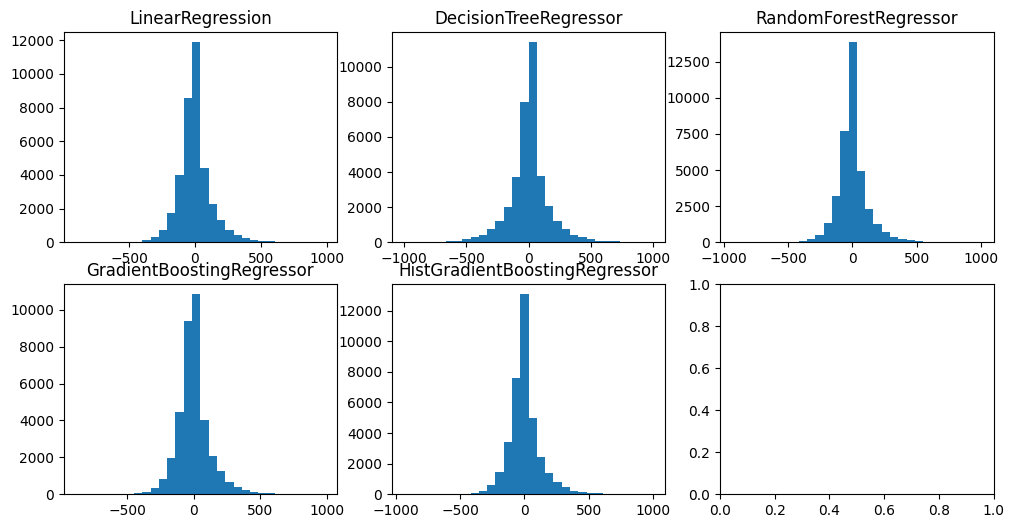

In [83]:
# Create subplot axes and indexing variables
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), sharey=False)
rix = 0
cix = 0

# run the predictions on all the models
for nextModel in models.keys():
    y_pred = nextModel.predict(X_val)
    mae = mean_absolute_error(y_true=y_val, y_pred=y_pred) # calculate error score
    models[nextModel] = mae # record the model error in the dictionary

    axes[rix, cix].hist(y_pred - y_val, bins=30)
    axes[rix, cix].set_title(f"{str(nextModel).split('(')[0]}")

    if cix < 2:
        cix += 1
    elif cix == 2:
        cix = 0
        rix += 1

# final results
models

### 10. Test Prediction

#### 10.1. Test Data Transformation

#### 10.2. Writing CSV Output

In [84]:
previous_pred = pd.read_csv("predicted.csv", header=None)
test_pred = model_gb.predict(X_test)
print(f"Prediction Shape: {test_pred.shape}")
np.savetxt("predicted.csv", test_pred)
print(f"{mean_absolute_error(y_true=previous_pred, y_pred=test_pred)}")

Prediction Shape: (60832,)
7.569944240366179


In [85]:
challenge.shape

(60832, 9)